In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency, beta

In [2]:
df=pd.read_csv('/Users/ankitshastri/Downloads/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### This is a webpage design data, with control group representing users who were exposed to old design and treatment group represnting users who were exposed to new design.
### The converted column is toggled to 1, where the user is successfully converted as a customer, otherwise it is populated as 0.
### The idea is to assess whether the new design was successfully able to convert more users into successful customers, with statistical significance.

In [4]:
pd.DataFrame((df['user_id'].value_counts()==1).value_counts())

,user_id
True,286690
False,3894


In [5]:
count=df['user_id'].value_counts()
unique_users=pd.DataFrame(count[count == 1].index, columns=['user_id'])
df = df.merge(unique_users, on=['user_id'])

In [6]:
df.shape

(286690, 5)

<Axes: xlabel='group', ylabel='Count'>

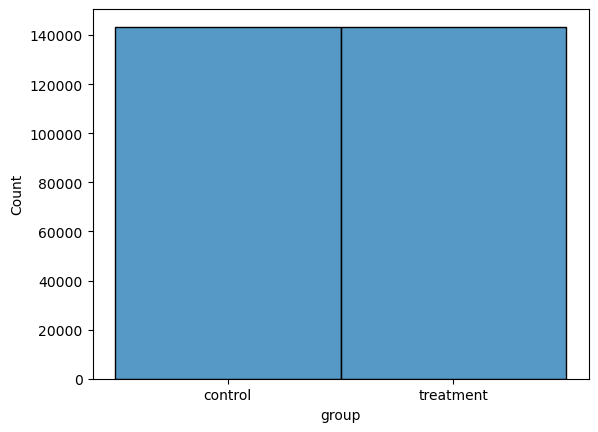

In [7]:
sns.histplot(df['group'])

In [8]:
#Proportion of users in either control or treatment group
control=df[df['group']=='control'].shape[0]/df.shape[0]
control

0.4998186194146988

<Axes: xlabel='converted', ylabel='Count'>

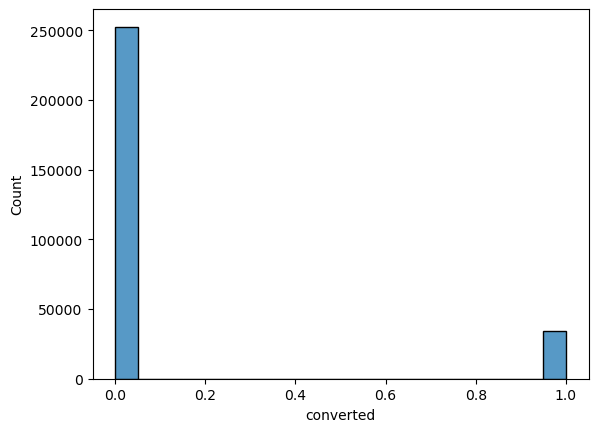

In [9]:
sns.histplot(df['converted'])

In [10]:
type(df['timestamp'])

pandas.core.series.Series

In [11]:
df['timestamp']=pd.to_datetime(df['timestamp'], format= '%Y-%m-%d %H:%M:%S.%f')
type(df['timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [12]:
df['Week_Number'] = df['timestamp'].dt.isocalendar().week
df.head()

,user_id,timestamp,group,landing_page,converted,Week_Number
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,3
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,3


In [13]:
df['Week_Number'].value_counts()

2    91380
3    91056
1    83745
4    20509
Name: Week_Number, dtype: Int64

## Frequentist Approach 

In [14]:
NUM_WEEKS = 4 # Vary number to get experiment data at weekly points in time
experiment_data = df[df['Week_Number'] <= NUM_WEEKS]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)
lift = round(treatment_conversion_perc - control_conversion_perc, 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 11.873%
Control Conversion Rate: 12.017%
Lift = -0.144%


### Null hypothesis: Control and teartment groups are independent 

In [15]:
#Contingency table for Chis-squared test
# Create Contingency Table for Chi Squared Test
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted
contingency_table = np.array([[control_converted, control_non_converted], 
                              [treatment_converted, treatment_non_converted]])
contingency_table

array([[ 17220, 126073],
       [ 17025, 126372]])

In [16]:
chi, p_value, _, _ = chi2_contingency(contingency_table, correction=False)
chi, p_value

(1.426794609399621, 0.23228827305833816)

### Since p value is greater than 0.05, we fail to reject the null hypothesis, that is accept that control group and treatment group are indeed independent 

## Bayesian Approach 

In [17]:
#We use Beta distribution as our prior distribution.

In [32]:
prior = df[(df['Week_Number'] == 1)]
prior_means = []
for i in range(10000):
   prior_means.append(prior.sample(1000)['converted'].mean())

In [33]:
prior_means[:5]

[0.127, 0.122, 0.117, 0.12, 0.124]

In [34]:
prior_alpha, prior_beta, _, _ = beta.fit(prior_means, floc=0, fscale=1)

In [35]:
NUM_WEEKS = 4 # Vary number to get experiment data at weekly points in time
experiment_data = df[(df['Week_Number'] > 3) & (df['Week_Number'] <= NUM_WEEKS)]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)
lift = round((treatment_conversion_perc - control_conversion_perc) / control_conversion_perc , 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 12.055%
Control Conversion Rate: 12.342%
Lift = -0.023%


In [36]:
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted

# Update Prior parameters with experiment conversion rates
posterior_control = beta(prior_alpha + control_converted, prior_beta + control_non_converted)
posterior_treatment = beta(prior_alpha + treatment_converted, prior_beta + treatment_non_converted)

# Sample from Posteriors
control_samples = posterior_control.rvs(1000)
treatment_samples = posterior_treatment.rvs(1000)
probability = np.mean(treatment_samples > control_samples)
print(f"Probability that treatment > control: {probability * 100}%")

Probability that treatment > control: 27.500000000000004%


In [37]:
(control_mu), (control_var) = posterior_control.stats()
(treatment_mu), (treatment_var) = posterior_treatment.stats()
print(f"Control Posterior: Mean: {control_mu}, Variance: {control_var}") 
print(f"Treatment Posterior: Mean: {treatment_mu}, Variance: {treatment_var}")

Control Posterior: Mean: 0.12298023638313225, Variance: 9.509291471585444e-06
Treatment Posterior: Mean: 0.120365138934023, Variance: 9.476028308177646e-06


In [38]:
lift_percentage = (treatment_samples - control_samples) / control_samples
print(f"Probability that we see a 1% lift: {np.mean((100 * lift_percentage) > 1) * 100}%")

Probability that we see a 1% lift: 18.7%


## Hence, with the Bayesian approach the results can be easiy converted into business metric for decision making, which is not entirely possible with frequnetist appraoch, which provides information only about the failure to reject or  rejection of Null hypothesis.

 def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_